<a href="https://colab.research.google.com/github/jjrodcast/MaskDectector/blob/master/Mask_Detector_Keras_vs_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 1. Cargamos librerías

In [1]:
!pip install mtcnn
from mtcnn import MTCNN
import numpy as np
import tensorflow as tf
import tensorflow.keras
import torch
from PIL import Image
import cv2
import timeit
import matplotlib.pyplot as plt
from predictor import predict
from bounding_box import resizeBoundingBox

Using TensorFlow backend.


#### 2. Variables de configuración

In [0]:
IMG_WIDTH = 160 # ancho de la imagen
IMG_HEIGHT = 160 # alto de la imagen
BBOX_PERCENTAGE = 0.05 # porcentage de ampliación del bounding box

#### 3. Carga de imagen original

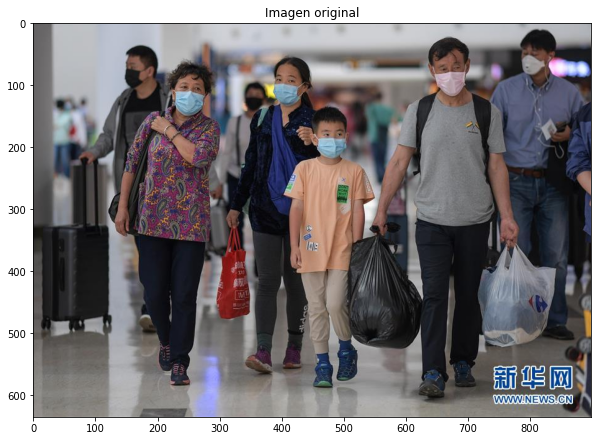

In [3]:
img = cv2.imread('test4.jpg')
img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img_color = cv2.resize(img_color, (1200, 800))
plt.figure(figsize=(10, 10))
plt.title("Imagen original")
plt.imshow(img_color)
plt.show()

#### 4. Cargamos modelo detector de rostros y mascarillas

In [0]:
# Detector de rostros (FaceNet)
detector = MTCNN()

### 5.1 Usando Clasificador de PyTorch

#### Detector de Mascaras (MaskNet)

In [0]:
model = tf.keras.models.load_model('mask_net.hdf5')
classes = ['no_mask', 'mask']

#### Detectamos si las personas tienen mascarillas o no

Faces: 7
Total time: 2.2646059159997094


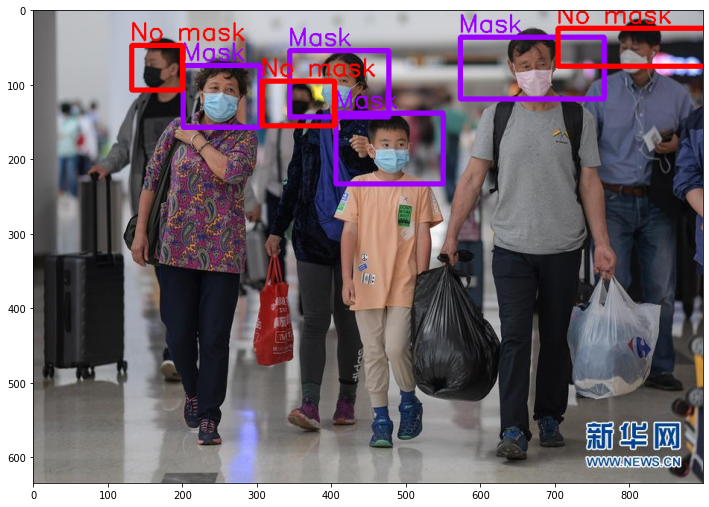

In [6]:
start_time = timeit.default_timer()
faces_mtcnn = detector.detect_faces(img_color)
print("Faces:", len(faces_mtcnn))
img_color_temp = img_color.copy()
index = 1
for face in faces_mtcnn:
    face['idx'] = index
    bbox = face['box']
    confidence = face['confidence']
    if confidence >= 0.70:
      x, y, w, h = resizeBoundingBox((img_color.shape[1], img_color.shape[0]), bbox, .10)
      img_face_slice = img_color[y:(y + h),x:(x + w), :]
      img_resize = cv2.resize(img_face_slice, (IMG_WIDTH, IMG_HEIGHT), cv2.INTER_AREA)
      pred = predict(model, classes, np.expand_dims(img_resize[:,:,::-1], axis = 0))
      color = (155,0,255) if pred == 'mask' else (255,0,0)
      cv2.rectangle(img_color_temp, (x, y), (x + w, y + h), color, 6)
      cv2.putText(img_color_temp, pred.replace("_", " ").capitalize(), (x-2, y-7), cv2.FONT_HERSHEY_SIMPLEX, 1.1, color, 2)
    index = index + 1
end_time = timeit.default_timer()
print("Total time:", (end_time - start_time))
plt.figure(figsize=(12, 12))
plt.imshow(img_color_temp)
plt.show()

### 5.2 Usando Clasificador de PyTorch

#### Importar modelo y utility para predecir (Mask or No Mask)

In [0]:
import predictor_pytorch as predictor
model_ft = torch.load('best_model_conv_ft2.model') # best_model_conv_ffe2.model

#### Ejecutamos el detector de rostros y predicciones

Faces: 7
Total time: 0.23199600299994927


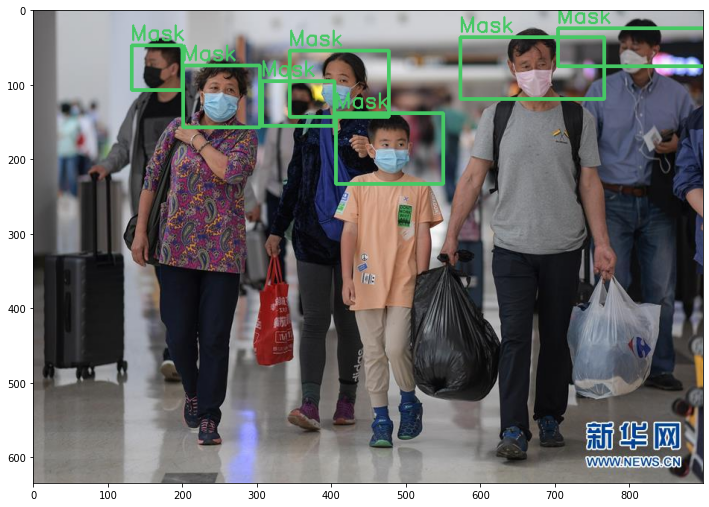

In [12]:
start_time = timeit.default_timer()
faces_mtcnn = detector.detect_faces(img_color)
print("Faces:", len(faces_mtcnn))
img_color_temp = img_color.copy()
index = 1
for face in faces_mtcnn:
    face['idx'] = index
    bbox = face['box']
    confidence = face['confidence']
    if confidence >= 0.70:
      x, y, w, h = resizeBoundingBox((img_color.shape[1], img_color.shape[0]), bbox, 0.10)
      img_face_slice = img_color[y:(y + h),x:(x + w), :]
      img_resize = cv2.resize(img_face_slice, (IMG_WIDTH, IMG_HEIGHT), cv2.INTER_AREA)

      pred , _ = predictor.model_predict(model = model_ft, image = img_resize , classes=['mask' , 'no_mask'])
      
      color = (70,200,100) if pred == 'mask' else (255,0,0)
      cv2.rectangle(img_color_temp, (x, y), (x + w, y + h), color, 4)
      cv2.putText(img_color_temp, pred.replace("_", " ").capitalize(), (x-2, y-7), cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)
    index = index + 1
end_time = timeit.default_timer()
print("Total time:", (end_time - start_time))
plt.figure(figsize=(12, 12))
plt.imshow(img_color_temp)
plt.show()